In [ ]:
import pandas as pd
import re
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
!git clone https://github.com/sophialee0628/Quantium-virtual-internship.git

Cloning into 'Quantium-virtual-internship'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 2), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [ ]:
%cd /content/Quantium-virtual-internship/

/content/Quantium-virtual-internship


In [ ]:
%ls

EDA_task1.ipynb  QVI_purchase_behaviour.csv
QVI_data.csv     QVI_transaction_data.xlsx


In [ ]:
data=pd.read_csv('QVI_data.csv')

In [ ]:
# to use the dt. we have to preprocess data to pd.datetime
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH']=data['DATE'].dt.strftime('%Y%m').astype('int')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
 12  YEARMONTH         264834 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(4)
memor

# Montly Analysis

**Client's Trial stores : # 77, 86,88**
- Compare Monthly data:
1. overall sales revenue
2. number of customers
3. number of transactions per customer
- Coefficent 

In [ ]:
byMonthly=data.groupby(['STORE_NBR','YEARMONTH'])

In [ ]:
totSales=byMonthly["TOT_SALES"].sum()
nCus=byMonthly['LYLTY_CARD_NBR'].nunique()
nTrx=byMonthly['TXN_ID'].count()
Trx_per_Cust = nTrx/ nCus

In [ ]:
storeCompare = pd.concat([totSales,nCus,Trx_per_Cust], axis=1)
storeCompare.columns = ["TOT_SALES", "nCustomers", "nTxnPerCustomers"]

In [ ]:
storeCompare=storeCompare.reset_index()

In [ ]:
storeCompare

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCustomers
0,1,201807,206.9,49,1.061224
1,1,201808,176.1,42,1.023810
2,1,201809,278.8,59,1.050847
3,1,201810,188.1,44,1.022727
4,1,201811,192.6,46,1.021739
...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667
3165,272,201903,442.3,50,1.060000
3166,272,201904,445.1,54,1.037037
3167,272,201905,314.6,34,1.176471


# Make preTrial

In [ ]:
observ_months = storeCompare["STORE_NBR"].value_counts()
full_observ_index = observ_months[observ_months == 12].index
full_observ = storeCompare[storeCompare["STORE_NBR"].isin(full_observ_index)]
preTrial = full_observ[full_observ["YEARMONTH"] < 201902]

In [ ]:
preTrial

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCustomers
0,1,201807,206.9,49,1.061224
1,1,201808,176.1,42,1.023810
2,1,201809,278.8,59,1.050847
3,1,201810,188.1,44,1.022727
4,1,201811,192.6,46,1.021739
...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000
3160,272,201810,430.6,44,1.159091
3161,272,201811,376.2,41,1.097561
3162,272,201812,403.9,47,1.000000


# Get correlation table

In [ ]:
def calcCorrTable(metricCol, storeComparison, inputTable=preTrial):
    """Calculate correlation for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform correlation test on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: Monthly correlation table between Trial and each Control stores.
    """
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Control_Str", "Corr_Score"])
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    for control in control_store_nbrs:
        concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Control_Str", "Corr_Score"])
        control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
        concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
        concat_df["Trial_Str"] = storeComparison
        concat_df["Control_Str"] = control
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        corrs = pd.concat([corrs, concat_df])
    return corrs

In [ ]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(["TOT_SALES", "nCustomers", "nTxnPerCustomers"], trial_num)])

In [ ]:
corr_table

,YEARMONTH,Trial_Str,Control_Str,Corr_Score
0,201807,77,1,-0.127100
1,201808,77,1,-0.171779
2,201809,77,1,-0.191927
3,201810,77,1,-0.217780
4,201811,77,1,-0.169064
...,...,...,...,...
2,201809,88,272,0.435983
3,201810,88,272,0.501235
4,201811,88,272,0.472945
5,201812,88,272,0.506498


# Calculate Distance

In [ ]:
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=preTrial):
    """Calculate standardised magnitude distance for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform distance calculation on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: Monthly magnitude-distance table between Trial and each Control stores.
    """
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Control_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists

In [ ]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCustomers"], trial_num)])

In [ ]:
dist_table

,TOT_SALES,nCustomers,nTxnPerCustomers,YEARMONTH,Trial_Str,Control_Str,magnitude
0,0.935431,0.980769,0.958035,201807,77,1,0.958078
1,0.942972,0.951923,0.993823,201808,77,1,0.962906
2,0.961503,0.836538,0.992126,201809,77,1,0.930056
3,0.988221,0.932692,0.989514,201810,77,1,0.970142
4,0.962149,0.951923,0.874566,201811,77,1,0.929546
...,...,...,...,...,...,...,...
2,0.207554,0.286822,0.462846,201809,88,272,0.319074
3,0.346797,0.387597,0.571497,201810,88,272,0.435297
4,0.286706,0.310078,0.623883,201811,88,272,0.406889
5,0.347151,0.387597,0.376456,201812,88,272,0.370402


# Combine Correalation and Distance

In [ ]:
def combine_corr_dist(metricCol, storeComparison, inputTable=preTrial):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Control_Str"])
    return combine

In [ ]:
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])

In [ ]:
compare_metrics_table1

,YEARMONTH,Trial_Str,Control_Str,Corr_Score,magnitude
0,201807,77,1,-1.0,0.935431
1,201808,77,1,-1.0,0.942972
2,201809,77,1,-1.0,0.961503
3,201810,77,1,-1.0,0.988221
4,201811,77,1,-1.0,0.962149
...,...,...,...,...,...
1794,201809,88,272,-1.0,0.207554
1795,201810,88,272,-1.0,0.346797
1796,201811,88,272,-1.0,0.286706
1797,201812,88,272,-1.0,0.347151


In [ ]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

In [ ]:
#Top 5 highest Composite Score for each Trial Store based on TOT_SALES
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Control_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Control_Str  Corr_Score  magnitude  CompScore
218         77          233         1.0   0.986477   0.993238
239         77          255         1.0   0.979479   0.989739
177         77          188         1.0   0.977663   0.988831
49          77           53         1.0   0.976678   0.988339
120         77          131         1.0   0.976267   0.988134 

     Trial_Str  Control_Str  Corr_Score  magnitude  CompScore
356         86          109         1.0   0.966783   0.983391
401         86          155         1.0   0.965876   0.982938
464         86          222         1.0   0.962280   0.981140
467         86          225         1.0   0.960512   0.980256
471         86          229         1.0   0.951704   0.975852 

     Trial_Str  Control_Str  Corr_Score  magnitude  CompScore
551         88           40         1.0   0.941165   0.970582
538         88           26         1.0   0.904377   0.952189
582         88           72         1.0   0.903800   0.951900
517 

For store 77 >> 233
For store 86 >> 109
For store 88 >> 40

# GET Trial Store's Data

In [ ]:
trial1=storeCompare.loc[(storeCompare['STORE_NBR']==77),:]
trial1.name='Trial Store #77'
trial2=storeCompare.loc[(storeCompare['STORE_NBR']==86),:]
trial2.name='Trial Store #86'
trial3=storeCompare.loc[(storeCompare['STORE_NBR']==88),:]
trial3.name='Trial Store #88'

# Visualization

## Select Control Store
- pre trial stores should have full 12 month obervation

### Calculate Correalation

In [ ]:
def cal_corr(i,measure):
    corrTable = pd.DataFrame( columns = ['Trial Store','Comparison Store', 'Measure', 'Correlation'])
    # for i in trial_num:
    trial_store_measure = preTrial.loc[preTrial.STORE_NBR == i, measure]
    for j in comparison_stores_num:
            comparison_store_measure = preTrial.loc[preTrial.STORE_NBR == j, measure]
            corr = np.corrcoef(trial_store_measure, comparison_store_measure)[0][1]
            corrTable = corrTable.append({
                'Trial Store': i, 
                'Comparison Store': j, 
                'Measure': measure, 
                'Correlation': corr}, ignore_index=True)
    return corrTable.sort_values(by=['Correlation'],ascending=False)

### Calculate Magnitude Distance

In [ ]:
yearmonth = preTrial.YEARMONTH.unique()

In [ ]:
def calc_distance(i,measure):
    distanceTable = pd.DataFrame( columns = ['Trial Store','Comparison Store', 'Year Month', 'Measure', 'Distance'])

    for j in comparison_stores_num:
            for month in yearmonth:
                trial_store_measures = preTrial.loc[ (preTrial.STORE_NBR == i) &  (preTrial.YEARMONTH == month), measure].values[0]
                comparison_store_measures = preTrial.loc[ (preTrial.STORE_NBR == j) & (preTrial.YEARMONTH == month), measure].values[0]
                distance = trial_store_measures - comparison_store_measures
                distanceTable = distanceTable.append({
                    'Trial Store': i, 
                    'Comparison Store': j, 
                    'Year Month': month,
                    'Measure' : measure,
                    'Distance' : abs(distance)}, ignore_index = True )
    return distanceTable.sort_values(by=['Distance'],ascending=False)

### Get overall Correlation Score

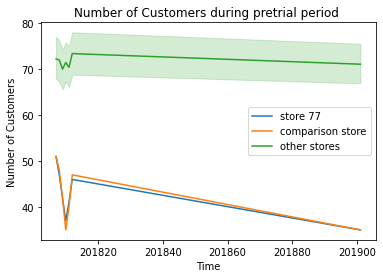

In [ ]:
preTrial_store77 = preTrial[ preTrial.STORE_NBR == 77]
preTrial_store233 = preTrial[ preTrial.STORE_NBR == 233]
preTrial_other = preTrial[ preTrial.STORE_NBR != 77]

ax = plt.subplot()
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store77, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store233, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_other, estimator= np.mean,ax = ax)
ax.set_title('Number of Customers during pretrial period ')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Customers')
ax.legend(['store 77', 'comparison store', 'other stores'])

In [ ]:
preTrial_store77.columns

Index(['STORE_NBR', 'YEARMONTH', 'TOT_SALES', 'nCustomers',
       'nTxnPerCustomers'],
      dtype='object')

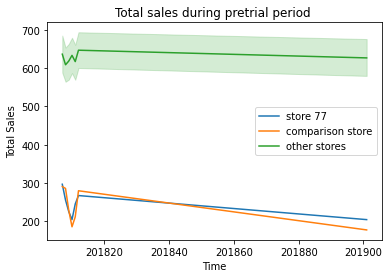

In [ ]:
preTrial_store77 = preTrial[ preTrial.STORE_NBR == 77]
preTrial_store233 = preTrial[ preTrial.STORE_NBR == 233]
preTrial_other = preTrial[ preTrial.STORE_NBR != 77]

ax = plt.subplot()
sns.lineplot(x = 'YEARMONTH', y = 'TOT_SALES' , data = preTrial_store77, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'TOT_SALES' , data = preTrial_store233, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'TOT_SALES' , data = preTrial_other, estimator= np.mean,ax = ax)
ax.set_title('Total sales during pretrial period ')
ax.set_xlabel('Time')
ax.set_ylabel('Total Sales')
ax.legend(['store 77', 'comparison store', 'other stores'])

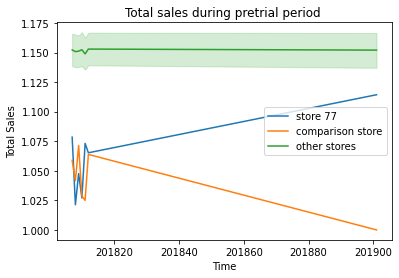

In [ ]:
preTrial_store77 = preTrial[ preTrial.STORE_NBR == 77]
preTrial_store233 = preTrial[ preTrial.STORE_NBR == 233]
preTrial_other = preTrial[ preTrial.STORE_NBR != 77]

ax = plt.subplot()
sns.lineplot(x = 'YEARMONTH', y = 'nTxnPerCustomers' , data = preTrial_store77, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nTxnPerCustomers' , data = preTrial_store233, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nTxnPerCustomers' , data = preTrial_other, estimator= np.mean,ax = ax)
ax.set_title('Total sales during pretrial period ')
ax.set_xlabel('Time')
ax.set_ylabel('Total Sales')
ax.legend(['store 77', 'comparison store', 'other stores'])

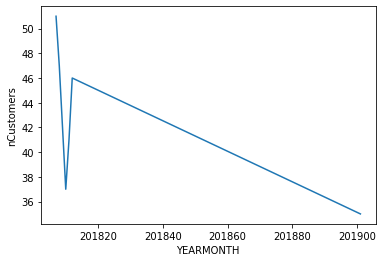

In [ ]:
ax = plt.subplot()
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store77, ax = ax)

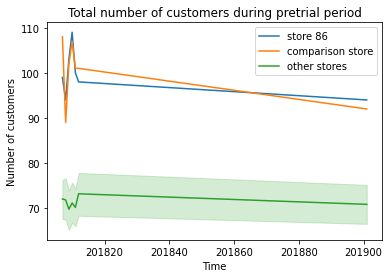

In [ ]:
preTrial_store86 = preTrial[ preTrial.STORE_NBR == 86]
preTrial_store109 = preTrial[ preTrial.STORE_NBR == 109]
preTrial_other = preTrial[ preTrial.STORE_NBR != 86]

ax = plt.subplot()
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store86, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store109, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_other, estimator= np.mean, ax = ax)
ax.set_title('Total number of customers during pretrial period')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(['store 86', 'comparison store', 'other stores'])

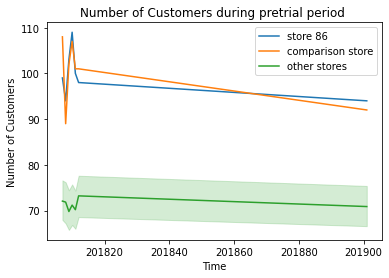

In [ ]:
preTrial_store86 = preTrial[ preTrial.STORE_NBR == 86]
preTrial_store109 = preTrial[ preTrial.STORE_NBR == 109]
preTrial_other = preTrial[ preTrial.STORE_NBR != 86]

ax = plt.subplot()
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store86, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store109, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_other, estimator= np.mean,ax = ax)
ax.set_title('Number of Customers during pretrial period ')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Customers')
ax.legend(['store 86', 'comparison store', 'other stores'])

# STORE 88

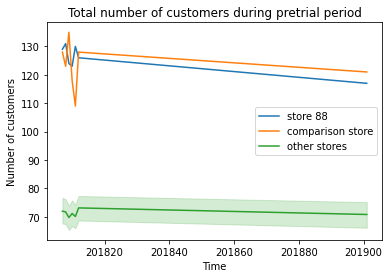

In [ ]:
preTrial_store88 = preTrial[ preTrial.STORE_NBR == 88]
preTrial_store40 = preTrial[ preTrial.STORE_NBR == 40]
preTrial_other = preTrial[ preTrial.STORE_NBR != 88]

ax = plt.subplot()
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store88, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_store40, ax = ax)
sns.lineplot(x = 'YEARMONTH', y = 'nCustomers' , data = preTrial_other, estimator= np.mean, ax = ax)
ax.set_title('Total number of customers during pretrial period')
ax.set_xlabel('Time')
ax.set_ylabel('Number of customers')
ax.legend(['store 88', 'comparison store', 'other stores'])